In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import time 
import data_loader

Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


In [2]:
# Your local path 
DATA_PATH = '/projects/zhanglab/users/johnson/data/GSE72056_processed.h5ad'

### Loading and normalize data

In [3]:
# raw data
adata = data_loader.load_annData(
    DATA_PATH)  # the directory with the `.mtx` file  
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [4]:
# basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# compute many metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# further filtering 
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

# size-factor and log transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# highly-variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


/n/home11/mjzhang/myenv_py310/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


### clustering

In [5]:
# default clustering pipeline
start_time = time.time()
# PCA
sc.tl.pca(adata, svd_solver='arpack')
# KNN
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
# Leiden-clustering based on PCA
sc.tl.leiden(adata)
print('leiden completed, time=%0.1fs' % (time.time() - start_time))
# UMAP embedding based on KNN
sc.tl.umap(adata)

/n/home11/mjzhang/myenv_py310/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/n/home11/mjzhang/myenv_py310/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/n/home11/mjzhang/myenv_py310/lib/python3.10/site-packages/umap/distances.py:108

leiden completed, time=8.7s


In [6]:
# BanditPAM with L1
from banditpam import KMedoids
start_time = time.time()
kmed = KMedoids(n_medoids=5, algorithm="BanditPAM")
kmed.fit(adata.X.toarray(), 'L1')
adata.obs['kmed_l1'] = kmed.labels
adata.obs['kmed_l1'] = adata.obs['kmed_l1'].astype('category')
print('kmed_l1 completed, time=%0.1fs' % (time.time() - start_time))

# BanditPAM with L2
from banditpam import KMedoids
start_time = time.time()
kmed = KMedoids(n_medoids=5, algorithm="BanditPAM")
kmed.fit(adata.X.toarray(), 'L2')
adata.obs['kmed_l2'] = kmed.labels
adata.obs['kmed_l2'] = adata.obs['kmed_l2'].astype('category')
print('kmed_l2 completed, time=%0.1fs' % (time.time() - start_time))

kmed_l1 completed, time=3161.7s
kmed_l2 completed, time=158.3s


In [14]:
adata.obs['kmed_l2'] = adata.obs['kmed_l2'].astype('category')

In [7]:
# Clustering lables are stored in adata.obs
adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,kmed_l1,kmed_l2
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776,4,0,3
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596,3,2,2
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736,0,2,0
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085,1,1,1
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490,6,2,2
...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,1153,3459.0,73.0,2.110436,1,1,1
TTTCTACTGAGGCA-1,1227,1224,3443.0,32.0,0.929422,3,0,0
TTTCTACTTCCTCG-1,622,622,1684.0,37.0,2.197150,3,0,2
TTTGCATGAGAGGC-1,454,452,1022.0,21.0,2.054795,3,0,2


/n/home11/mjzhang/myenv_py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/n/home11/mjzhang/myenv_py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/n/home11/mjzhang/myenv_py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


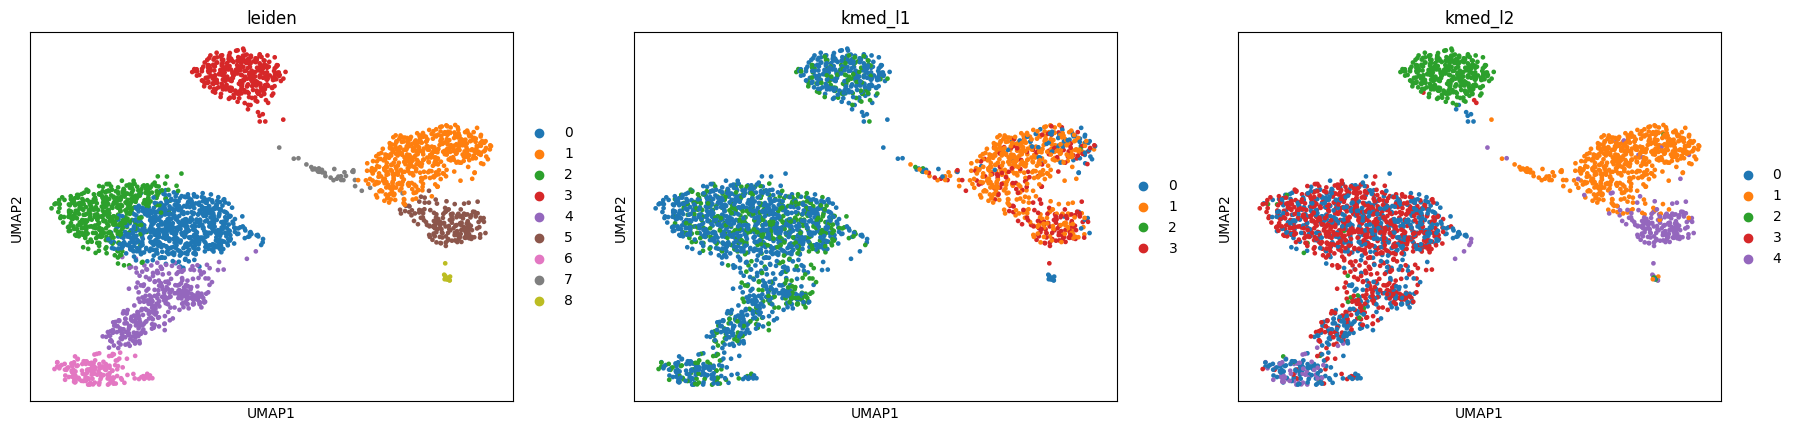

In [15]:
sc.pl.umap(adata, color=['leiden', 'kmed_l1', 'kmed_l2'])

### BanditPAM demo

1.2482391595840454
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2]


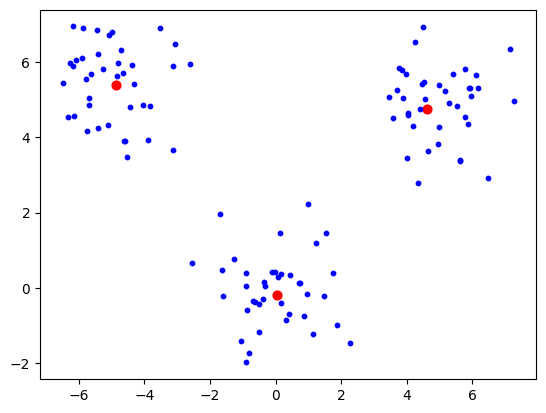

In [9]:
from banditpam import KMedoids
import numpy as np
import matplotlib.pyplot as plt

# Generate data from a Gaussian Mixture Model with the given means:
np.random.seed(0)
n_per_cluster = 40
means = np.array([[0,0], [-5,5], [5,5]])
X = np.vstack([np.random.randn(n_per_cluster, 2) + mu for mu in means])

# Fit the data with BanditPAM:
kmed = KMedoids(n_medoids=3, algorithm="BanditPAM")
kmed.fit(X, 'L2')

print(kmed.average_loss)  # prints 1.2482391595840454
print(kmed.labels)  # prints cluster assignments [0] * 40 + [1] * 40 + [2] * 40

# Visualize the data and the medoids:
for p_idx, point in enumerate(X):
    if p_idx in map(int, kmed.medoids):
        plt.scatter(X[p_idx, 0], X[p_idx, 1], color='red', s = 40)
    else:
        plt.scatter(X[p_idx, 0], X[p_idx, 1], color='blue', s = 10)

plt.show()